In [14]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
# from keras.layers.experimental.preprocessing import Normalization
from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image

print('setup successful!')
print(tf.__version__)

setup successful!
2.16.1


In [15]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "../input/garbage-classification/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [16]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [17]:
df.head()

,filename,category
0,clothes/clothes147.jpg,7
1,cardboard/cardboard738.jpg,1
2,clothes/clothes1625.jpg,7
3,battery/battery921.jpg,5
4,clothes/clothes2906.jpg,7


brown-glass/brown-glass593.jpg


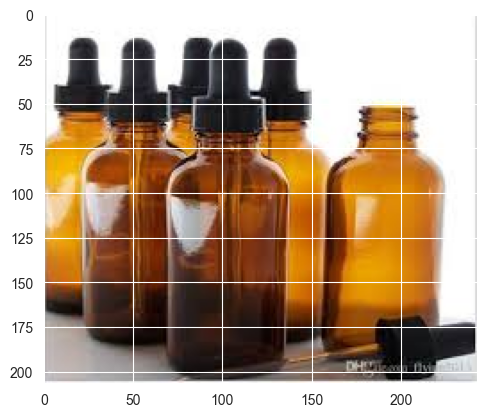

In [18]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

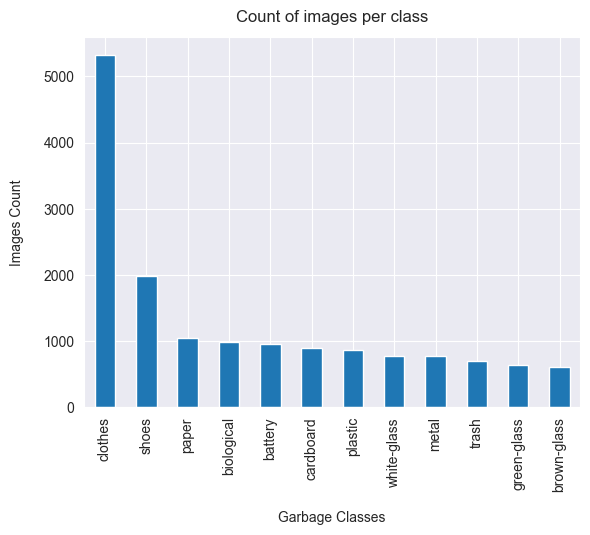

In [19]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [20]:
xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,886,068 (79.67 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [21]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [22]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  12412 validate size =  1551 test size =  1552


In [23]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [24]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [25]:
EPOCHS = 40
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

Epoch 1/40


/Users/alix/PycharmProjects/SmartBin/ai/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/193 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - categorical_accuracy: 0.7202 - loss: 1.0138 - val_categorical_accuracy: 0.9212 - val_loss: 0.3075
Epoch 2/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:02 3s/step - categorical_accuracy: 0.9531 - loss: 0.2676

2024-03-22 13:29:35.734392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9531 - loss: 0.1345 - val_categorical_accuracy: 0.9333 - val_loss: 0.1850
Epoch 3/40


2024-03-22 13:29:36.349257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - categorical_accuracy: 0.9415 - loss: 0.2421 - val_categorical_accuracy: 0.9355 - val_loss: 0.2432
Epoch 4/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:15 3s/step - categorical_accuracy: 0.9062 - loss: 0.2539

2024-03-22 13:38:47.083782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9062 - loss: 0.1276 - val_categorical_accuracy: 1.0000 - val_loss: 0.0491
Epoch 5/40


2024-03-22 13:38:47.710068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - categorical_accuracy: 0.9519 - loss: 0.1790 - val_categorical_accuracy: 0.9388 - val_loss: 0.2189
Epoch 6/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:00 3s/step - categorical_accuracy: 0.9844 - loss: 0.0971

2024-03-22 13:47:51.954125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0488 - val_categorical_accuracy: 0.9333 - val_loss: 0.1164
Epoch 7/40


2024-03-22 13:47:52.555777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - categorical_accuracy: 0.9620 - loss: 0.1469 - val_categorical_accuracy: 0.9440 - val_loss: 0.2006
Epoch 8/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:39 3s/step - categorical_accuracy: 0.9219 - loss: 0.2461

2024-03-22 13:57:27.543817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9219 - loss: 0.1237 - val_categorical_accuracy: 0.8667 - val_loss: 0.1326
Epoch 9/40


2024-03-22 13:57:28.175170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - categorical_accuracy: 0.9649 - loss: 0.1285 - val_categorical_accuracy: 0.9466 - val_loss: 0.1913
Epoch 10/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:08 3s/step - categorical_accuracy: 0.8906 - loss: 0.2769

2024-03-22 14:07:00.257346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.8906 - loss: 0.1392 - val_categorical_accuracy: 0.9333 - val_loss: 0.0666
Epoch 11/40


2024-03-22 14:07:00.861110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - categorical_accuracy: 0.9714 - loss: 0.1120 - val_categorical_accuracy: 0.9447 - val_loss: 0.1886
Epoch 12/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - categorical_accuracy: 0.9062 - loss: 0.2341

2024-03-22 14:15:58.275931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9062 - loss: 0.1177 - val_categorical_accuracy: 1.0000 - val_loss: 0.0231
Epoch 13/40


2024-03-22 14:15:58.868102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - categorical_accuracy: 0.9744 - loss: 0.0967 - val_categorical_accuracy: 0.9479 - val_loss: 0.1875
Epoch 14/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:41 3s/step - categorical_accuracy: 0.9844 - loss: 0.1093

2024-03-22 14:25:04.212700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9844 - loss: 0.0550 - val_categorical_accuracy: 0.9333 - val_loss: 0.0785
Epoch 15/40


2024-03-22 14:25:04.896800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - categorical_accuracy: 0.9750 - loss: 0.0928 - val_categorical_accuracy: 0.9486 - val_loss: 0.1829
Epoch 16/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:05 3s/step - categorical_accuracy: 0.9844 - loss: 0.0753

2024-03-22 14:34:15.561457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0378 - val_categorical_accuracy: 1.0000 - val_loss: 0.0334
Epoch 17/40


2024-03-22 14:34:16.175340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - categorical_accuracy: 0.9796 - loss: 0.0803 - val_categorical_accuracy: 0.9492 - val_loss: 0.1761
Epoch 18/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - categorical_accuracy: 0.9844 - loss: 0.0975

2024-03-22 14:43:21.260249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0490 - val_categorical_accuracy: 0.9333 - val_loss: 0.2138
Epoch 19/40


2024-03-22 14:43:21.856306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - categorical_accuracy: 0.9818 - loss: 0.0740 - val_categorical_accuracy: 0.9466 - val_loss: 0.1781
Epoch 20/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:05 3s/step - categorical_accuracy: 0.9531 - loss: 0.1504

2024-03-22 14:52:19.155151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9531 - loss: 0.0756 - val_categorical_accuracy: 0.9333 - val_loss: 0.0741
Epoch 21/40


2024-03-22 14:52:19.768823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - categorical_accuracy: 0.9848 - loss: 0.0674 - val_categorical_accuracy: 0.9466 - val_loss: 0.1736
Epoch 22/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:12 3s/step - categorical_accuracy: 0.9844 - loss: 0.0708

2024-03-22 15:01:34.730424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0356 - val_categorical_accuracy: 1.0000 - val_loss: 0.0320
Epoch 23/40


2024-03-22 15:01:35.358007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - categorical_accuracy: 0.9861 - loss: 0.0628 - val_categorical_accuracy: 0.9492 - val_loss: 0.1749
Epoch 24/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - categorical_accuracy: 0.9844 - loss: 0.0477

2024-03-22 15:10:37.537969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0240 - val_categorical_accuracy: 1.0000 - val_loss: 0.0170
Epoch 25/40


2024-03-22 15:10:38.130946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - categorical_accuracy: 0.9889 - loss: 0.0553 - val_categorical_accuracy: 0.9518 - val_loss: 0.1748
Epoch 26/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:07 3s/step - categorical_accuracy: 0.9531 - loss: 0.1185

2024-03-22 15:19:46.086980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9531 - loss: 0.0595 - val_categorical_accuracy: 0.9333 - val_loss: 0.1334
Epoch 27/40


2024-03-22 15:19:46.697331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - categorical_accuracy: 0.9874 - loss: 0.0544 - val_categorical_accuracy: 0.9499 - val_loss: 0.1718
Epoch 28/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - categorical_accuracy: 0.9688 - loss: 0.0929

2024-03-22 15:28:43.531956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9688 - loss: 0.0467 - val_categorical_accuracy: 0.9333 - val_loss: 0.1959
Epoch 29/40


2024-03-22 15:28:44.127494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - categorical_accuracy: 0.9907 - loss: 0.0490 - val_categorical_accuracy: 0.9466 - val_loss: 0.1786
Epoch 30/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:09 3s/step - categorical_accuracy: 1.0000 - loss: 0.0494

2024-03-22 15:37:49.068196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 1.0000 - loss: 0.0248 - val_categorical_accuracy: 1.0000 - val_loss: 0.0091
Epoch 31/40


2024-03-22 15:37:49.660633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - categorical_accuracy: 0.9925 - loss: 0.0443 - val_categorical_accuracy: 0.9531 - val_loss: 0.1790
Epoch 32/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:00 3s/step - categorical_accuracy: 0.9688 - loss: 0.0675

2024-03-22 15:46:52.165344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9688 - loss: 0.0339 - val_categorical_accuracy: 1.0000 - val_loss: 0.0244
Epoch 33/40


2024-03-22 15:46:52.765518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - categorical_accuracy: 0.9935 - loss: 0.0415 - val_categorical_accuracy: 0.9499 - val_loss: 0.1744
Epoch 34/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:19 3s/step - categorical_accuracy: 1.0000 - loss: 0.0374

2024-03-22 15:56:01.623083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 1.0000 - loss: 0.0188 - val_categorical_accuracy: 0.9333 - val_loss: 0.1183
Epoch 35/40


2024-03-22 15:56:02.212174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - categorical_accuracy: 0.9949 - loss: 0.0377 - val_categorical_accuracy: 0.9512 - val_loss: 0.1767
Epoch 36/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 7:56 2s/step - categorical_accuracy: 1.0000 - loss: 0.0329

2024-03-22 16:05:00.438284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 1.0000 - loss: 0.0165 - val_categorical_accuracy: 1.0000 - val_loss: 6.7141e-04
Epoch 37/40


2024-03-22 16:05:01.019742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - categorical_accuracy: 0.9947 - loss: 0.0337 - val_categorical_accuracy: 0.9538 - val_loss: 0.1779
Epoch 38/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:09 3s/step - categorical_accuracy: 1.0000 - loss: 0.0237

2024-03-22 16:14:11.156431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 1.0000 - loss: 0.0119 - val_categorical_accuracy: 1.0000 - val_loss: 0.0160
Epoch 39/40


2024-03-22 16:14:11.764417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - categorical_accuracy: 0.9960 - loss: 0.0329 - val_categorical_accuracy: 0.9518 - val_loss: 0.1753
Epoch 40/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 8:04 3s/step - categorical_accuracy: 0.9844 - loss: 0.0458

2024-03-22 16:23:23.113616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9844 - loss: 0.0230 - val_categorical_accuracy: 0.9333 - val_loss: 0.1716


2024-03-22 16:23:23.723422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [28]:
model.save_weights("modeltrash.weights.h5")

In [29]:
model.save('modeltrash.keras')

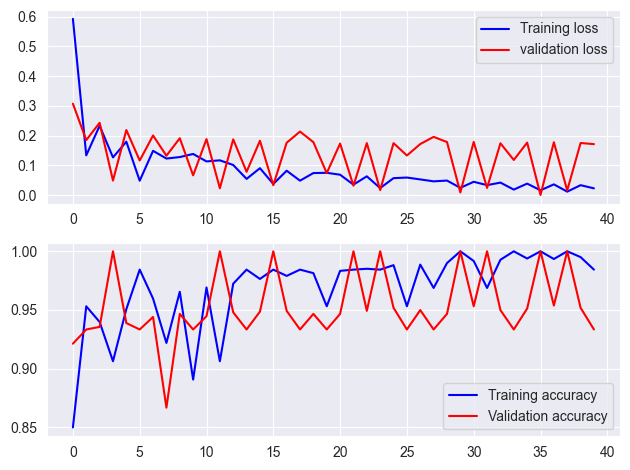

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [41]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [46]:
score, acc = model.evaluate(X_test, y_test,verbose=2, batch_size= 256)
print('test accuracy:', acc)

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

NameError: name 'X_test' is not defined

In [47]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# Charger le modèle pré-entraîné
model_trained = load_model('modeltrash.keras')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_1', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 320, 320, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_1', 'trainable': True, 'dtype': 'float32', 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'xception_preprocessing', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 320, 320, 3]}}, {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'xception', 'trainable': False, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 320, 320, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 320, 320, 3]}, 'name': 'block1_conv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 320, 320, 3], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1_conv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 159, 159, 32]}, 'name': 'block1_conv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 159, 159, 32], 'dtype': 'float32', 'keras_history': ['block1_conv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block1_conv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 159, 159, 32]}, 'name': 'block1_conv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 159, 159, 32], 'dtype': 'float32', 'keras_history': ['block1_conv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 159, 159, 32]}, 'name': 'block1_conv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 159, 159, 32], 'dtype': 'float32', 'keras_history': ['block1_conv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block1_conv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 64]}, 'name': 'block1_conv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 64], 'dtype': 'float32', 'keras_history': ['block1_conv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block1_conv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 64]}, 'name': 'block1_conv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 64], 'dtype': 'float32', 'keras_history': ['block1_conv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block2_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 64]}, 'name': 'block2_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 64], 'dtype': 'float32', 'keras_history': ['block1_conv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 128]}, 'name': 'block2_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 128], 'dtype': 'float32', 'keras_history': ['block2_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block2_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 128]}, 'name': 'block2_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 128], 'dtype': 'float32', 'keras_history': ['block2_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block2_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 128]}, 'name': 'block2_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 128], 'dtype': 'float32', 'keras_history': ['block2_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block2_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 128]}, 'name': 'block2_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 128], 'dtype': 'float32', 'keras_history': ['block2_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 64]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 64], 'dtype': 'float32', 'keras_history': ['block1_conv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block2_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 157, 157, 128]}, 'name': 'block2_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 157, 157, 128], 'dtype': 'float32', 'keras_history': ['block2_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 128]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_12', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 79, 79, 128], [None, 79, 79, 128]]}, 'name': 'add_12', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['block2_pool', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 128]}, 'name': 'block3_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['add_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block3_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 128]}, 'name': 'block3_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['block3_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 256]}, 'name': 'block3_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 256], 'dtype': 'float32', 'keras_history': ['block3_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block3_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 256]}, 'name': 'block3_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 256], 'dtype': 'float32', 'keras_history': ['block3_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block3_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 256]}, 'name': 'block3_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 256], 'dtype': 'float32', 'keras_history': ['block3_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block3_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 256]}, 'name': 'block3_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 256], 'dtype': 'float32', 'keras_history': ['block3_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 128]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 128], 'dtype': 'float32', 'keras_history': ['add_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block3_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 79, 79, 256]}, 'name': 'block3_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 79, 79, 256], 'dtype': 'float32', 'keras_history': ['block3_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 256]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_13', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 40, 40, 256], [None, 40, 40, 256]]}, 'name': 'add_13', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['block3_pool', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 256]}, 'name': 'block4_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['add_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block4_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 256]}, 'name': 'block4_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['block4_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 728]}, 'name': 'block4_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 728], 'dtype': 'float32', 'keras_history': ['block4_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block4_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 728]}, 'name': 'block4_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 728], 'dtype': 'float32', 'keras_history': ['block4_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block4_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 728]}, 'name': 'block4_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 728], 'dtype': 'float32', 'keras_history': ['block4_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block4_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 728]}, 'name': 'block4_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 728], 'dtype': 'float32', 'keras_history': ['block4_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': False, 'dtype': 'float32', 'filters': 728, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 256]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 256], 'dtype': 'float32', 'keras_history': ['add_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block4_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 40, 40, 728]}, 'name': 'block4_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 40, 40, 728], 'dtype': 'float32', 'keras_history': ['block4_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_14', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_14', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block4_pool', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block5_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block5_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block5_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block5_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block5_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block5_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_15', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_15', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block5_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_14', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block6_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block6_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block6_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block6_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block6_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block6_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_16', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_16', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block6_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_15', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block7_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block7_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block7_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block7_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block7_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block7_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_17', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_17', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block7_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_16', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block8_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block8_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block8_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block8_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block8_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block8_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block8_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block8_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block8_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block8_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_18', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_18', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block8_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block9_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block9_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block9_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block9_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block9_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block9_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block9_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block9_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block9_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block9_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_19', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_19', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block9_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block10_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block10_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block10_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block10_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block10_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block10_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block10_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block10_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block10_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block10_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_20', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block10_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block11_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block11_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block11_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block11_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block11_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block11_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block11_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block11_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block11_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block11_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_21', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block11_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block12_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block12_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block12_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block12_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block12_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block12_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block12_sepconv3_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv3_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block12_sepconv3', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv3_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block12_sepconv3_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block12_sepconv3_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_22', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 20, 20, 728], [None, 20, 20, 728]]}, 'name': 'add_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block12_sepconv3_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block13_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block13_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block13_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block13_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block13_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block13_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block13_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block13_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block13_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block13_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block13_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block13_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'block13_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['block13_sepconv2_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block13_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 1024]}, 'name': 'block13_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 1024], 'dtype': 'float32', 'keras_history': ['block13_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 728]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 728], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block13_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 20, 20, 1024]}, 'name': 'block13_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 20, 20, 1024], 'dtype': 'float32', 'keras_history': ['block13_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 1024]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1024], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_23', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 10, 10, 1024], [None, 10, 10, 1024]]}, 'name': 'add_23', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1024], 'dtype': 'float32', 'keras_history': ['block13_pool', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1024], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block14_sepconv1', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 1536, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 1024]}, 'name': 'block14_sepconv1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1024], 'dtype': 'float32', 'keras_history': ['add_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block14_sepconv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 1536]}, 'name': 'block14_sepconv1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1536], 'dtype': 'float32', 'keras_history': ['block14_sepconv1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block14_sepconv1_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 1536]}, 'name': 'block14_sepconv1_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1536], 'dtype': 'float32', 'keras_history': ['block14_sepconv1_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'block14_sepconv2', 'trainable': False, 'dtype': 'float32', 'depth_multiplier': 1, 'filters': 2048, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 1536]}, 'name': 'block14_sepconv2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 1536], 'dtype': 'float32', 'keras_history': ['block14_sepconv1_act', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'block14_sepconv2_bn', 'trainable': False, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 2048]}, 'name': 'block14_sepconv2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 2048], 'dtype': 'float32', 'keras_history': ['block14_sepconv2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'block14_sepconv2_act', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 2048]}, 'name': 'block14_sepconv2_act', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 10, 2048], 'dtype': 'float32', 'keras_history': ['block14_sepconv2_bn', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_2', 0, 0]], 'output_layers': [['block14_sepconv2_act', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 10, 2048]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 12, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}}], 'build_input_shape': [None, 320, 320, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 320, 320, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['categorical_accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_1', 'trainable': True, 'dtype': 'float32', 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'xception_preprocessing', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 320, 320, 3]}}.

Exception encountered: Could not locate function 'xception_preprocessing'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'xception_preprocessing', 'registered_name': 'function'}

In [ ]:
# img_path = getRandomPath() 
img_path = "cardboard220.jpg"
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Normalize the image
normalized_img = normalization_layer(img_array)

# Make prediction
predictions = model.predict(normalized_img)
# Afficher les probabilités de chaque classe
print(predictions)

# Déterminer la classe prédite en fonction de la probabilité maximale
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Afficher la classe prédite
print("Classe prédite:", predicted_class)